In [32]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import warnings
warnings.filterwarnings("ignore")

In [33]:
df = pd.read_csv("netflix.csv")

In [34]:
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,23-05-2002,1.242857,1.145714,1.156429,1.196429,104790000,1.196429
1,24-05-2002,1.225000,1.197143,1.214286,1.210000,11104800,1.210000
2,28-05-2002,1.232143,1.157143,1.213571,1.157143,6609400,1.157143
3,29-05-2002,1.164286,1.085714,1.164286,1.103571,6757800,1.103571
4,30-05-2002,1.107857,1.071429,1.107857,1.071429,10154200,1.071429


In [35]:
df.shape

(4881, 7)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4881 entries, 0 to 4880
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4881 non-null   object 
 1   High       4881 non-null   float64
 2   Low        4881 non-null   float64
 3   Open       4881 non-null   float64
 4   Close      4881 non-null   float64
 5   Volume     4881 non-null   int64  
 6   Adj Close  4881 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 267.1+ KB


In [37]:
df.describe()

,High,Low,Open,Close,Volume,Adj Close
count,4881.000000,4881.000000,4881.000000,4881.000000,4.881000e+03,4881.000000
mean,107.003361,103.742674,105.388477,105.434149,1.679949e+07,105.434149
std,159.326383,154.662309,157.007060,157.073188,1.936794e+07,157.073188
min,0.410714,0.346429,0.377857,0.372857,2.856000e+05,0.372857
25%,3.977143,3.838571,3.901429,3.906429,6.286300e+06,3.906429
50%,22.261429,21.150000,21.524286,21.632856,1.082310e+07,21.632856
75%,127.430000,123.589996,125.949997,125.389999,2.015640e+07,125.389999
max,646.840027,630.859985,642.229981,639.099976,3.234140e+08,639.099976


In [38]:
df['Date']=pd.to_datetime(df["Date"])

<Axes: xlabel='Date', ylabel='High'>

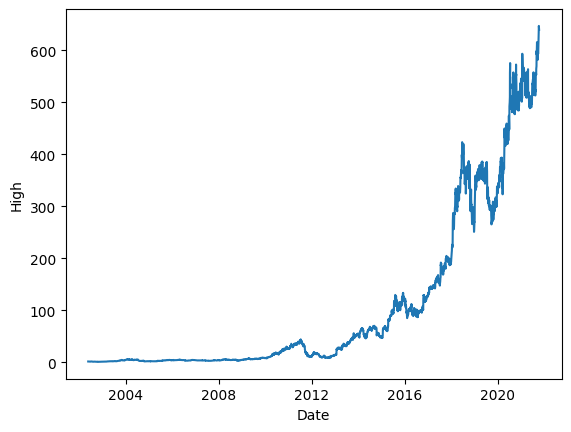

In [39]:
sns.lineplot(data=df,x=df["Date"],y=df["High"])

<Axes: xlabel='Date', ylabel='Low'>

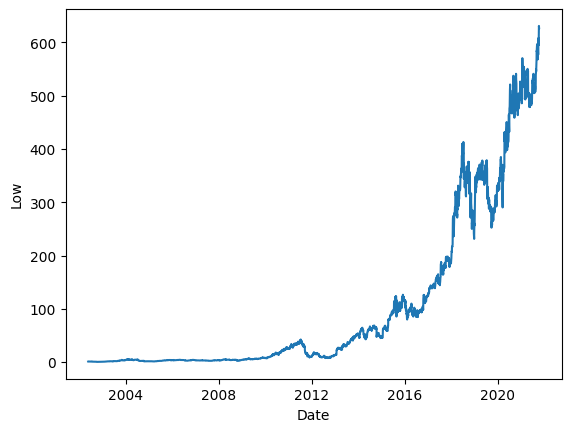

In [40]:
sns.lineplot(data=df,x=df["Date"],y=df["Low"])

<Axes: xlabel='Date', ylabel='Open'>

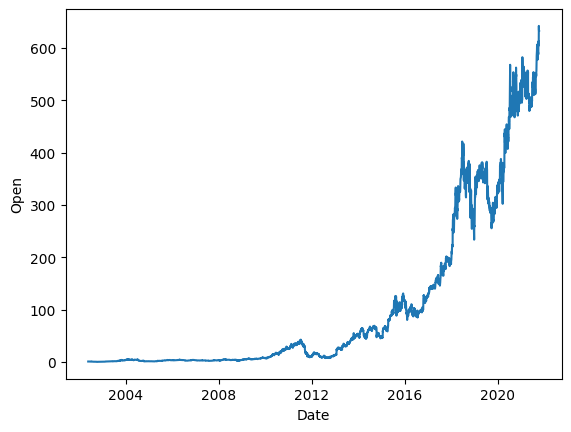

In [41]:
sns.lineplot(data=df,x=df["Date"],y=df["Open"])

<Axes: xlabel='Date', ylabel='Close'>

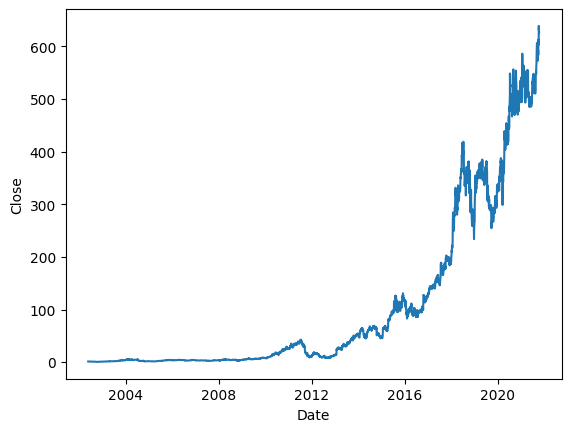

In [42]:
sns.lineplot(data=df,x=df["Date"],y=df["Close"])

<Axes: xlabel='Date', ylabel='Adj Close'>

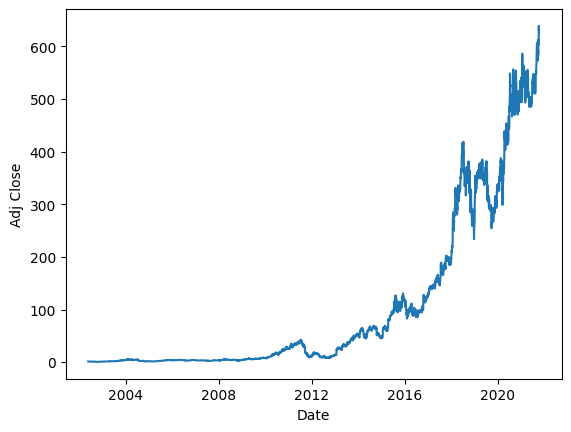

In [43]:
sns.lineplot(data=df,x=df["Date"],y=df["Adj Close"])

10 epoch loss 0.004896911
20 epoch loss 0.004136373
30 epoch loss 0.002814107
40 epoch loss 2.2327426e-05
50 epoch loss 8.0843245e-05
60 epoch loss 0.00020400622
70 epoch loss 6.117966e-05
80 epoch loss 2.9941413e-05
90 epoch loss 2.8997538e-05


<function matplotlib.pyplot.show(close=None, block=None)>

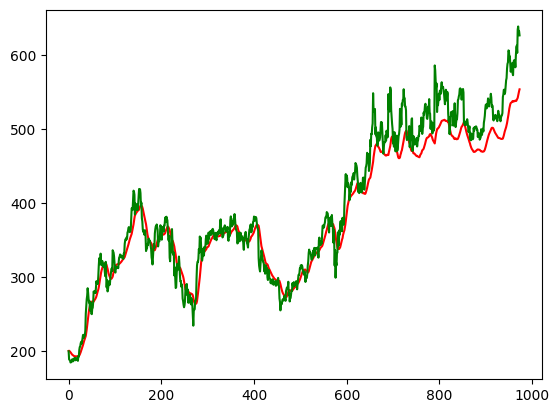

In [44]:
closed_prices = df["Close"]

seq_len = 15

mm = MinMaxScaler()
scaled_price = mm.fit_transform(np.array(closed_prices)[... , None]).squeeze()

X = []
y = []

for i in range(len(scaled_price) - seq_len):
    X.append(scaled_price[i : i + seq_len])
    y.append(scaled_price[i + seq_len])

X = np.array(X)[... , None]
y = np.array(y)[... , None]
    
train_x = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
train_y = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
test_x = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
test_y = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()

class Model(nn.Module):
    def __init__(self , input_size , hidden_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size , hidden_size , batch_first = True)
        self.fc = nn.Linear(hidden_size , 1)
    def forward(self , x):
        output , (hidden , cell) = self.lstm(x)
        return self.fc(hidden[-1 , :])
model = Model(1 , 64)

optimizer = torch.optim.Adam(model.parameters() , lr = 0.001)
loss_fn = nn.MSELoss()

num_epochs = 100

for epoch in range(num_epochs):
    output = model(train_x)
    loss = loss_fn(output , train_y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0 and epoch != 0:
        print(epoch , "epoch loss" , loss.detach().numpy())

model.eval()
with torch.no_grad():
    output = model(test_x)

pred = mm.inverse_transform(output.numpy())
real = mm.inverse_transform(test_y.numpy())

plt.plot(pred.squeeze() , color = "red" , label = "predicted")
plt.plot(real.squeeze() , color = "green" , label = "real")
plt.show